In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import CatalogPrior
from smc.images import ImageAttributes

import torch
# torch.cuda.is_available()
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

In [2]:
num_images = 1
img_dim = 10 # Needs to be square for now
img_width = img_dim
img_height = img_dim
max_objects = 5
psf_stdev = 3.25
background_intensity = 19200

image_attributes = ImageAttributes(img_width = img_width,
                                   img_height = img_height,
                                   max_objects = max_objects,
                                   psf_stdev = psf_stdev,
                                   background_intensity = background_intensity)

true_counts, true_fluxes, true_locs, true_total_intensities, images = image_attributes.generate(num_images)

In [3]:
for i in range(num_images):
    print(f"image {i+1}",
          "\ncount\n", true_counts[i].round().item(),
          "\ntotal flux\n", true_fluxes[i].sum().item(),
          "\nloc\n", true_locs[i].cpu().numpy(), "\n\n")

image 1 
count
 5 
total flux
 311887.96875 
loc
 [[7.9214535 0.6638794]
 [2.8712397 5.223489 ]
 [6.609723  1.8982654]
 [0.5796147 4.27513  ]
 [6.6050234 3.4229348]] 




True count: 5
True total flux: 311887.96875

Starting the sampler...
iteration 5, temperature = 0.000931879854761064, posterior mean count = 4.731235027313232
iteration 10, temperature = 0.00400039367377758, posterior mean count = 4.904787063598633
iteration 15, temperature = 0.009054305031895638, posterior mean count = 4.902759552001953
iteration 20, temperature = 0.016162777319550514, posterior mean count = 4.8931779861450195
iteration 25, temperature = 0.027004718780517578, posterior mean count = 4.890597343444824
iteration 30, temperature = 0.04432687163352966, posterior mean count = 4.8818583488464355
iteration 35, temperature = 0.07424372434616089, posterior mean count = 4.870232582092285
iteration 40, temperature = 0.13470682501792908, posterior mean count = 4.859467029571533
iteration 45, temperature = 0.2819312512874603, posterior mean count = 4.855513095855713
iteration 50, temperature = 0.680296778678894, posterior mean count = 4.863792419433594
iteration 55, temperature = 0

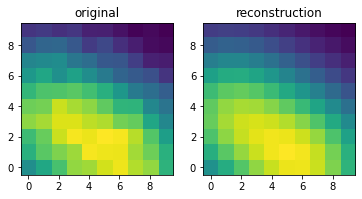

In [4]:
max_objects_smc = max_objects + 2
pad = 5
prior = CatalogPrior(max_objects_smc, img_width, img_height, pad, background_intensity/3.)
smc = SMCsampler(images[0], image_attributes, prior, num_blocks = max_objects_smc+1, catalogs_per_block = 500, max_smc_iters = 1000)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

smc.run(print_progress = True)
smc.summarize()